In [208]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [169]:
df= pd.read_csv('insurance.csv')

In [170]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [171]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [172]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [173]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [175]:
df.shape

(1338, 7)

## EDA

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<Axes: xlabel='charges', ylabel='Count'>

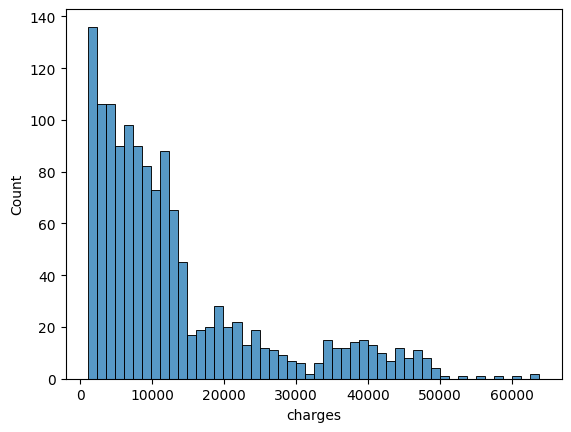

In [177]:
sns.histplot(df.charges, bins=50)

<Axes: xlabel='age', ylabel='Count'>

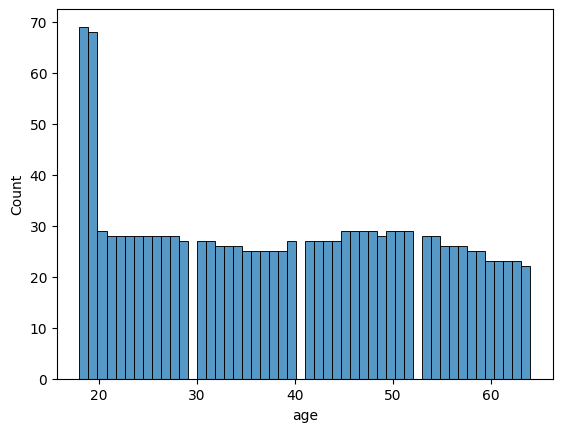

In [178]:
sns.histplot(df.age, bins=50)

## Split train test val 

In [179]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.charges.values
y_val = df_val.charges.values
y_test = df_test.charges.values

del df_train['charges']
del df_val['charges']
del df_test['charges']

In [180]:
num=['age','bmi','children']
cat=['sex','smoker','region']

In [181]:
df_train_full[cat].nunique()

sex       2
smoker    2
region    4
dtype: int64

In [182]:
from sklearn.metrics import mutual_info_score

In [183]:
def mutual_info_charges(series):
    return mutual_info_score(series, df_train_full.charges)

In [184]:
mi = df_train_full[cat].apply(mutual_info_charges)
mi.sort_values(ascending=False)

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


region    1.385626
sex       0.692852
smoker    0.508078
dtype: float64

In [185]:
df_train_full[num].corrwith(df_train_full.charges).abs()

age         0.281721
bmi         0.197316
children    0.071885
dtype: float64

In [186]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Linear Regression 

In [187]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [188]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [189]:
print(f"{'r':<8}{'score':<12}{'trainn_acc':<12}")
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    trainn_acc=metrics.r2_score(y_val, y_pred)
    print(f"{r:<8}{score:<12.2f}{trainn_acc:<12.2f}")

r       score       trainn_acc  
0       82853.40    -39.73      
0.01    6766.92     0.73        
0.1     6767.22     0.73        
1       6770.39     0.73        
5       6786.08     0.73        
10      6809.08     0.72        
100     7495.74     0.67        


## Decision Tree Regression

In [ ]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

names = dv.get_feature_names_out().tolist()
print(names)

In [193]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- smoker=yes <= 0.50
|   |--- value: [8415.72]
|--- smoker=yes >  0.50
|   |--- value: [30891.36]



## Random Forest Regression

In [195]:
rf=RandomForestRegressor(n_estimators=10,random_state=1,n_jobs=-1)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred)).round(2)


np.float64(5660.19)

In [196]:
trainn_acc=metrics.r2_score(y_val, y_pred)

trainn_acc

0.8098971134699664

In [197]:
scores=[]
for n in range(10,201,10):
    rf=RandomForestRegressor(n_estimators=n,random_state=1,n_jobs=-1)
    rf.fit(X_train,y_train)

    y_pred = rf.predict(X_val)
    score=np.sqrt(mean_squared_error(y_val, y_pred)).round(3)

    trainn_acc=metrics.r2_score(y_val, y_pred)

    scores.append((n,score,trainn_acc))

In [198]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse','trainn_acc'])
df_scores

,n_estimators,rmse,trainn_acc
0,10,5660.186,0.809897
1,20,5547.474,0.817393
2,30,5530.350,0.818518
3,40,5517.425,0.819366
4,50,5505.582,0.820140
5,60,5515.338,0.819502
6,70,5488.794,0.821236
7,80,5494.696,0.820851
8,90,5497.874,0.820644
9,100,5497.838,0.820646


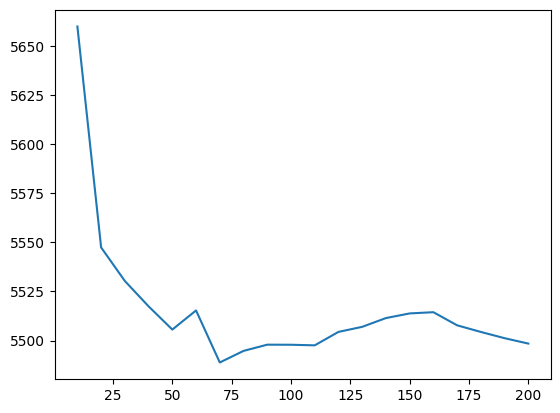

In [199]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [200]:
scores={}
for d in [10, 15, 20, 25]:
    for n in range(10,201,10):
        s=[]
        rf=RandomForestRegressor(n_estimators=n,random_state=1,n_jobs=-1,max_depth=d)
        rf.fit(X_train,y_train)

        y_pred = rf.predict(X_val)
        score=np.sqrt(mean_squared_error(y_val, y_pred)).round(3)

        trainn_acc=metrics.r2_score(y_val, y_pred)
        s.append(trainn_acc)
    scores[d] = np.mean(s)
    print(f'for {d} value of r2 value {scores[d]}')

for 10 value of r2 value 0.8215903087086314
for 15 value of r2 value 0.8205733423635901
for 20 value of r2 value 0.8205703659853416
for 25 value of r2 value 0.8206070488626396


## XGBOOST

In [203]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [204]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=50,
        evals=watchlist
    )
y_pred = model.predict(dval)
val_r2 = metrics.r2_score(y_val, y_pred)
print(f"Validation R²: {val_r2:.4f}")


[0]	train-rmse:8670.95007	val-rmse:9938.50890
[1]	train-rmse:6665.06465	val-rmse:7988.83477
[2]	train-rmse:5362.62923	val-rmse:6755.02545
[3]	train-rmse:4495.25441	val-rmse:6128.42906
[4]	train-rmse:3965.11783	val-rmse:5777.27226
[5]	train-rmse:3561.34255	val-rmse:5626.00822
[6]	train-rmse:3272.08097	val-rmse:5538.06622
[7]	train-rmse:3107.95780	val-rmse:5481.92817
[8]	train-rmse:2986.87190	val-rmse:5449.21340
[9]	train-rmse:2867.58519	val-rmse:5453.02780
[10]	train-rmse:2789.15221	val-rmse:5448.37589
[11]	train-rmse:2723.14051	val-rmse:5449.16258
[12]	train-rmse:2602.00749	val-rmse:5467.62950
[13]	train-rmse:2539.33944	val-rmse:5462.13931
[14]	train-rmse:2516.34535	val-rmse:5462.36631
[15]	train-rmse:2392.29640	val-rmse:5462.15513
[16]	train-rmse:2305.73917	val-rmse:5471.13720
[17]	train-rmse:2250.27018	val-rmse:5467.39525
[18]	train-rmse:2223.79191	val-rmse:5472.42800
[19]	train-rmse:2173.44222	val-rmse:5482.20573
[20]	train-rmse:2111.33189	val-rmse:5510.84967
[21]	train-rmse:2100.89

In [205]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=50,
        evals=watchlist
    )
y_pred = model.predict(dval)
val_r2 = metrics.r2_score(y_val, y_pred)
print(f"Validation R²: {val_r2:.4f}")

[0]	train-rmse:10645.87505	val-rmse:11979.21463
[1]	train-rmse:9744.26385	val-rmse:11045.95530
[2]	train-rmse:8943.85876	val-rmse:10220.96526
[3]	train-rmse:8229.81105	val-rmse:9511.66161
[4]	train-rmse:7595.93632	val-rmse:8896.79681
[5]	train-rmse:7034.92086	val-rmse:8340.02678
[6]	train-rmse:6536.50776	val-rmse:7881.08382
[7]	train-rmse:6096.47118	val-rmse:7472.49339
[8]	train-rmse:5710.31371	val-rmse:7140.72369
[9]	train-rmse:5368.61782	val-rmse:6854.41872
[10]	train-rmse:5059.46891	val-rmse:6612.94833
[11]	train-rmse:4792.60731	val-rmse:6415.65101
[12]	train-rmse:4548.23807	val-rmse:6233.02803
[13]	train-rmse:4344.68444	val-rmse:6076.62636
[14]	train-rmse:4166.65965	val-rmse:5965.12367
[15]	train-rmse:3986.16941	val-rmse:5864.44714
[16]	train-rmse:3850.89385	val-rmse:5784.39599
[17]	train-rmse:3719.76597	val-rmse:5716.21801
[18]	train-rmse:3596.13541	val-rmse:5662.52441
[19]	train-rmse:3489.58628	val-rmse:5622.89531
[20]	train-rmse:3407.66533	val-rmse:5584.09707
[21]	train-rmse:333

In [206]:
results = []
max_depth_values = [2, 4,5, 6,7, 8,9, 10, 12]

for depth in max_depth_values:
    params = {
        'eta': 0.1,
        'max_depth': depth,
        'min_child_weight': 1,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'nthread': 8,
        'seed': 1,
        'verbosity': 0
    }

    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dval, 'val')],
        evals_result=evals_result,
        verbose_eval=False
    )

    # Predictions
    y_pred_train = model.predict(dtrain)
    y_pred_val = model.predict(dval)

    # Compute metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_r2 = metrics.r2_score(y_train, y_pred_train)
    val_r2 = metrics.r2_score(y_val, y_pred_val)

    results.append((depth, train_rmse, val_rmse, train_r2, val_r2))

# Display results
print(f"{'Depth':<8}{'Train_RMSE':<12}{'Val_RMSE':<12}{'Train_R2':<12}{'Val_R2':<12}")
print("-" * 56)
for depth, train_rmse, val_rmse, train_r2, val_r2 in results:
    print(f"{depth:<8}{train_rmse:<12.2f}{val_rmse:<12.2f}{train_r2:<12.4f}{val_r2:<12.4f}")

Depth   Train_RMSE  Val_RMSE    Train_R2    Val_R2      
--------------------------------------------------------
2       3720.78     5363.73     0.8981      0.8293      
4       2411.82     5501.87     0.9572      0.8204      
5       1696.56     5658.91     0.9788      0.8100      
6       1050.39     5666.67     0.9919      0.8095      
7       551.89      5712.18     0.9978      0.8064      
8       358.08      5684.79     0.9991      0.8082      
9       320.03      5776.80     0.9992      0.8020      
10      314.18      5926.66     0.9993      0.7916      
12      312.19      5916.56     0.9993      0.7923      


In [207]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=50,
        evals=watchlist
    )
y_pred = model.predict(dval)
val_r2 = metrics.r2_score(y_val, y_pred)
print(f"Validation R²: {val_r2:.4f}")

[0]	train-rmse:10709.46064	val-rmse:12041.00090
[1]	train-rmse:9874.10209	val-rmse:11161.09428
[2]	train-rmse:9140.00229	val-rmse:10388.25774
[3]	train-rmse:8494.95040	val-rmse:9712.16752
[4]	train-rmse:7931.16646	val-rmse:9129.36889
[5]	train-rmse:7439.78101	val-rmse:8615.04044
[6]	train-rmse:7012.95601	val-rmse:8202.48698
[7]	train-rmse:6641.51413	val-rmse:7824.96801
[8]	train-rmse:6322.14907	val-rmse:7530.51001
[9]	train-rmse:6045.29599	val-rmse:7247.88254
[10]	train-rmse:5809.20101	val-rmse:7022.38898
[11]	train-rmse:5606.81777	val-rmse:6815.50470
[12]	train-rmse:5430.88667	val-rmse:6635.35064
[13]	train-rmse:5279.57985	val-rmse:6500.14743
[14]	train-rmse:5147.54886	val-rmse:6359.34234
[15]	train-rmse:5033.63095	val-rmse:6241.28181
[16]	train-rmse:4934.31905	val-rmse:6142.23948
[17]	train-rmse:4849.59558	val-rmse:6046.02950
[18]	train-rmse:4774.30444	val-rmse:5958.91225
[19]	train-rmse:4710.02703	val-rmse:5906.06679
[20]	train-rmse:4652.96568	val-rmse:5848.01848
[21]	train-rmse:460